# Vehicle Re-identification using Transformer and Contrastive Learning

In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

from dataset import VehicleReIDDataset, dataloader_train_test_split
from vit import ViTEncoder
from loss import TripletLoss
from utils import get_hard_triplets, extract_embeddings
from performance_analysis import compute_cmc_rankn, compute_map

In [22]:
# DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')
print(DEVICE)

cuda


In [ ]:
# initilaizing model
model = ViTEncoder(
    img_size=224,
    patch_size=8,
    in_chans=3,
    embed_dim=1024,
    depth=4,
    n_heads=12,
    mlp_ratio=4.,
    qkv_bias=True,
    p=0.1,
    attn_p=0.1,
    out_dim=512
)

# defining transformations
# transform = transforms.Compose([
#     transforms.Resize((384, 384), interpolation=3),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Training

In [26]:
def train(model, dataloader, optimizer, loss_fn, device, epochs=10):
    model.train()
    train_loss_hist = []
    for epoch in range(epochs):
        epoch_loss = 0
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)

            # Extract embeddings
            embeddings = model(images)

            # Hard triplet selection
            triplets = get_hard_triplets(embeddings, labels)
            if len(triplets) == 0:
                continue

            anchor, positive, negative = zip(*triplets)
            anchor = torch.stack([embeddings[i] for i in anchor])
            positive = torch.stack([embeddings[i] for i in positive])
            negative = torch.stack([embeddings[i] for i in negative])

            # Compute loss
            loss = loss_fn(anchor, positive, negative)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= len(dataloader)
        train_loss_hist.append(epoch_loss)
        print(f'Epoch {epoch+1:3}/{epochs:3} | Loss: {epoch_loss:.4f}')
    return train_loss_hist

In [27]:
# Initialize dataset and dataloader
vric_dataset = VehicleReIDDataset(root_dir='data/VRIC_dataset/train_images', labels_file='data/VRIC_dataset/vric_train.txt', name='VRIC', transform=transform)
train_loader = DataLoader(vric_dataset, batch_size=100, shuffle=True)

model.load_state_dict(torch.load('trained_models/model_10_veri_carla.pth', map_location=DEVICE)) # to initialize model with pre-trained weights
model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
loss_fn = TripletLoss(margin=0.5)

In [30]:
# Train model
train_loss_hist = train(model, train_loader, optimizer, loss_fn, DEVICE, epochs=5)

100%|██████████| 549/549 [07:07<00:00,  1.28it/s]


Epoch   1/  5 | Loss: 0.0025


100%|██████████| 549/549 [07:04<00:00,  1.29it/s]


Epoch   2/  5 | Loss: 0.0024


100%|██████████| 549/549 [07:04<00:00,  1.29it/s]


Epoch   3/  5 | Loss: 0.0021


100%|██████████| 549/549 [07:09<00:00,  1.28it/s]


Epoch   4/  5 | Loss: 0.0035


100%|██████████| 549/549 [07:05<00:00,  1.29it/s]

Epoch   5/  5 | Loss: 0.0052


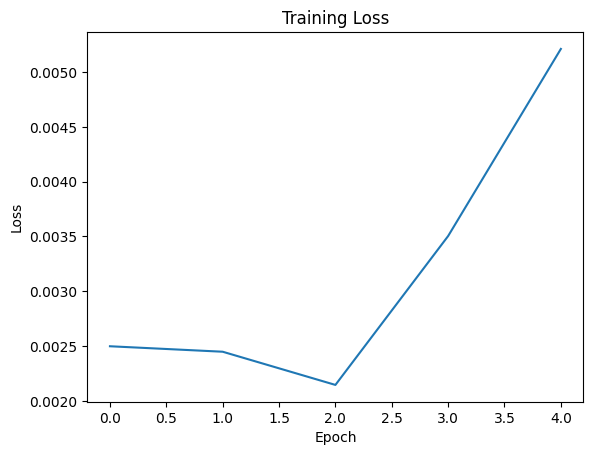

In [31]:
# Plot training loss
plt.figure()
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_loss_hist)
plt.show()

In [32]:
# Saving model
torch.save(model.state_dict(), 'trained_models/model_10_vric.pth')

### Inference

In [33]:
model.load_state_dict(torch.load('trained_models/model_10_vric.pth', map_location=DEVICE))
model.to(DEVICE)

model.eval()

ViTEncoder(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-3): 4 x Block(
      (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=256, out_features=768, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1024, out_features=256, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
  (projection_head): Sequential(
    (0): Linear(in_features=256,

In [34]:
def infer(model, image_path, device=DEVICE, transform=transform):
    '''
    Extracts embeddings for a single image.
    '''
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = model(image)
    return embedding.cpu().numpy().flatten()

trial_image_path = './data/VeRi_CARLA_dataset/image_gallery/20220710050038_0_44.jpg'
infer(model, trial_image_path)

array([ 2.53767539e-02,  3.32693825e-03,  6.22670259e-03,  2.18827780e-02,
       -3.08333896e-02, -6.72188327e-02, -4.31431681e-02, -5.69921546e-02,
        5.11082672e-02,  6.81745559e-02,  4.72131670e-02, -2.88390648e-02,
        1.28844321e-01, -2.88343187e-02, -3.62200923e-02, -1.11193657e-02,
       -1.83038544e-02, -3.57879773e-02,  3.90492268e-02, -3.32525894e-02,
       -3.70997526e-02,  3.10531110e-02,  4.02898900e-02, -2.63845138e-02,
       -1.05371945e-01,  4.81418967e-02,  2.90016867e-02, -3.07422653e-02,
       -3.43246013e-02, -4.64328118e-02,  2.17108037e-02,  4.56595160e-02,
       -2.27691103e-02, -4.14670110e-02,  1.31866280e-02,  4.18895110e-02,
        3.59414704e-02,  4.64660265e-02,  3.91433388e-02,  1.89065374e-02,
        1.75279435e-02,  3.19397449e-01, -3.73757370e-02,  4.38875630e-02,
        1.14536518e-02, -1.95076149e-02, -2.96878647e-02,  2.85848863e-02,
       -4.85843122e-02, -1.52495271e-03,  2.41053551e-02, -9.97889787e-03,
       -1.14667602e-02,  

### Performance Analysis

In [35]:
model.load_state_dict(torch.load('trained_models/model_10_vric.pth', map_location=DEVICE))
model.to(DEVICE)

model.eval()

ViTEncoder(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-3): 4 x Block(
      (norm1): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=256, out_features=768, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm2): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1024, out_features=256, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
  (projection_head): Sequential(
    (0): Linear(in_features=256,

In [36]:
# query_dataset = VehicleReIDDataset(root_dir='data/VeRi_CARLA_dataset/image_query', name='VeRi_CARLA', transform=transform)
# gallery_dataset = VehicleReIDDataset(root_dir='data/VeRi_CARLA_dataset/image_gallery', name='VeRi_CARLA', transform=transform)

vric_query = VehicleReIDDataset(root_dir='data/VRIC_dataset/probe_images', labels_file='data/VRIC_dataset/vric_probe.txt', name='VRIC', transform=transform)
vric_gallery = VehicleReIDDataset(root_dir='data/VRIC_dataset/gallery_images', labels_file='data/VRIC_dataset/vric_gallery.txt', name='VRIC', transform=transform)

query_loader = DataLoader(vric_query, batch_size=1, shuffle=False)
gallery_loader = DataLoader(vric_gallery, batch_size=1, shuffle=False)

query_embeddings, query_labels = extract_embeddings(model, query_loader, DEVICE)
gallery_embeddings, gallery_labels = extract_embeddings(model, gallery_loader, DEVICE)

Rank-1 Accuracy: 1.28%
Rank-5 Accuracy: 3.45%
Rank-10 Accuracy: 4.91%


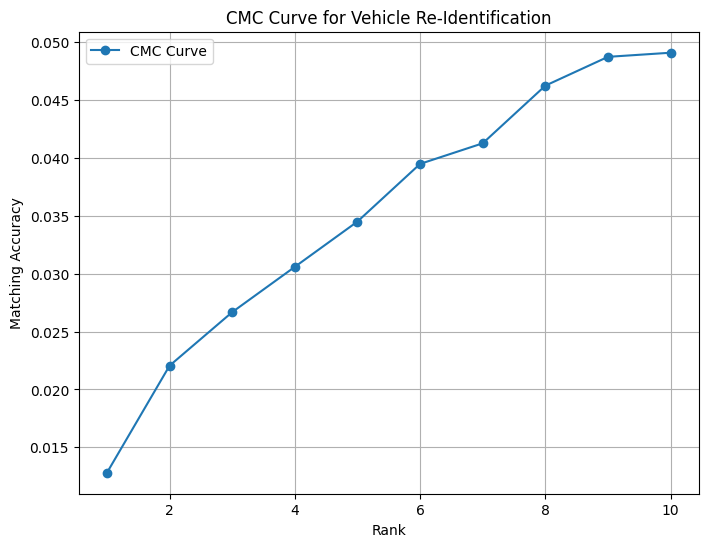

In [ ]:
# Compute cosine similarity
similarity = cosine_similarity(query_embeddings, gallery_embeddings)

map_score = compute_map(similarity, query_labels, gallery_labels)
print(f'Mean Average Precision (mAP): {map_score * 100:.2f}%')

cmc_curve, rank_1, rank_5, rank_10 = compute_cmc_rankn(similarity, query_labels, gallery_labels)

print(f'Rank-1 Accuracy: {rank_1:.2f}%')
print(f'Rank-5 Accuracy: {rank_5:.2f}%' if rank_5 else '')
print(f'Rank-10 Accuracy: {rank_10:.2f}%' if rank_10 else '')

ranks = np.arange(1, len(cmc_curve) + 1)
plt.figure(figsize=(8, 6))
plt.plot(ranks, cmc_curve, marker='o', linestyle='-', label='CMC Curve')
plt.xlabel('Rank')
plt.ylabel('Matching Accuracy')
plt.title('CMC Curve for Vehicle Re-Identification')
plt.legend()
plt.grid()
plt.show()